# RAW Crop

## Goal
Correlation between literacy, rainfall, and crop production across India.

It is intuitive that good rainfall is conducive to good production. How do the regions perform during poor rainfall in the rainy season?
We also want to cross match with the literacy rate of the region to see if higher levels of literacy affects crop production.

So we dive into the questions that are posed to understand and interpret the results.

## Environment Preparation and Loading of Data

### Spark Environment Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive # link wrong in blog
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Provides findspark.init() to make pyspark importable as a regular library.
# Resource : https://pypi.org/project/findspark/
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark

### Common Imports and Functions

In [3]:
## Common Imports
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import *
import random
#  Setup
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

In [4]:
## Common Operations
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

In [5]:
## Common Functionalities
### Splitting the states into respective zones
zones = { 
    'north': ['Jammu and Kashmir', 'Himachal Pradesh', 'Punjab', 'Uttarakhand', 'Uttar Pradesh', 'Haryana', 'Chandigarh', 'Delhi'],
    'south': ['Andhra Pradesh', 'Karnataka', 'Kerala', 'Tamil Nadu', 'Telangana', 'Lakshadweep', 'Andaman and Nicobar Islands', 'Puducherry'],
    'east': ['Bihar', 'Orissa', 'Odisha', 'Jharkhand', 'West Bengal'],
    'west': [ 'Rajasthan' , 'Gujarat', 'Goa', 'Maharashtra', 'Dadra and Nagar Haveli'],
    'central': ['Madhya Pradesh', 'Chhattisgarh'],
    'north_east': ['Assam', 'Sikkim', 'Nagaland', 'Meghalaya', 'Manipur', 'Mizoram', 'Tripura', 'Arunachal Pradesh'],
}

# Generating reverse map for State to Zone mapping
zoneMap = {}
for key in zones:
  for state in zones[key]:
    zoneMap[state] = key
# zoneMap

In [6]:
## Common Functions

### User Defined Functoin for mapping state to zone
def find_zone(state):
  # print(state)
  return zoneMap[state]

zone_udf_string = udf(lambda state: find_zone(state), StringType())

### Find WQI for each data point
# Based on the following references:
# https://link.springer.com/article/10.1007/s13201-017-0579-4
# http://www.indiaenvironmentportal.org.in/files/water%20quality%20index.pdf
# https://www.youtube.com/watch?v=HTkNmmMoUzE
# https://www.youtube.com/watch?v=LtXfIYYb8F4
# http://iitk.ac.in/iwd/wq/drinkingwater.htm


### Loading Data

In [7]:
# Crop Data
cfile = "/content/drive/Shareddrives/DA-231-O-Sem-Project-2021/data/crop/apy.csv"
_cdf = spark.read.option("header",True).option("inferSchema",True).csv(cfile)
_cdf.show(5, truncate=False)

# Water quality data
wfile = "/content/drive/Shareddrives/DA-231-O-Sem-Project-2021/data/water/water-quality-*.jsonl"
_wdf = spark.read.json(wfile)
_wdf.show(5,  truncate=False)


+---------------------------+-------------+---------+-----------+-------------------+------+----------+
|State_Name                 |District_Name|Crop_Year|Season     |Crop               |Area  |Production|
+---------------------------+-------------+---------+-----------+-------------------+------+----------+
|Andaman and Nicobar Islands|NICOBARS     |2000     |Kharif     |Arecanut           |1254.0|2000      |
|Andaman and Nicobar Islands|NICOBARS     |2000     |Kharif     |Other Kharif pulses|2.0   |1         |
|Andaman and Nicobar Islands|NICOBARS     |2000     |Kharif     |Rice               |102.0 |321       |
|Andaman and Nicobar Islands|NICOBARS     |2000     |Whole Year |Banana             |176.0 |641       |
|Andaman and Nicobar Islands|NICOBARS     |2000     |Whole Year |Cashewnut          |720.0 |165       |
+---------------------------+-------------+---------+-----------+-------------------+------+----------+
only showing top 5 rows

+-------+--------+-------+-------------

## Show the trend of top 5 crops per region in each season for the years 2000-2014

In [8]:
windowRegion = Window.partitionBy("RegionSeasonCrop_Year").orderBy(col("avg_production").desc())

cal_zone = _cdf.select(col("State_Name"),
                       col("District_Name"),
                       col("Crop_Year"),
                       col("Season"),
                       col("Crop"),
                       col("Area"),
                       col("Production"),
                       zone_udf_string(trim("State_Name")).alias('Region'),)\
               .filter(~(trim(col('Season')) == 'Whole Year'))\
               .withColumn("RegionSeasonCrop_Year", concat('Region','Season', 'Crop_Year'))

grp_statewise = cal_zone.groupBy("State_Name").agg(
                            avg("Production").alias("avg_production"),
                            avg("Area").alias("avg_area"))
grp_statewise.show(20)

+--------------------+------------------+------------------+
|          State_Name|    avg_production|          avg_area|
+--------------------+------------------+------------------+
|            Nagaland|  3048.33544973545|1589.8455843469064|
|           Karnataka|14795.294705261853|11063.592911580643|
|              Odisha|12531.749602947133| 8915.978395564976|
|              Kerala|11183.839801670143| 4734.655407331976|
|          Tamil Nadu|25292.076732357353|11534.968876611418|
|        Chhattisgarh| 13106.39158194334|10557.267852572306|
|      Andhra Pradesh| 38820.68500455196|15218.795431078988|
|      Madhya Pradesh| 24582.18975135655|20381.415390841034|
|              Punjab|173600.41993006994|43063.635294117645|
|             Manipur| 7054.318493150685|3059.1247863247863|
|                 Goa|12853.638861788619| 5331.842741935484|
|             Mizoram|1616.7948840206186|1086.8009897172237|
|Dadra and Nagar H...| 7026.125475285171|1507.6615969581749|
|    Himachal Pradesh| 7

/usr/lib/python3.7/socket.py:660: ResourceWarning: unclosed <socket.socket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 39792), raddr=('127.0.0.1', 45731)>
  self._sock = None


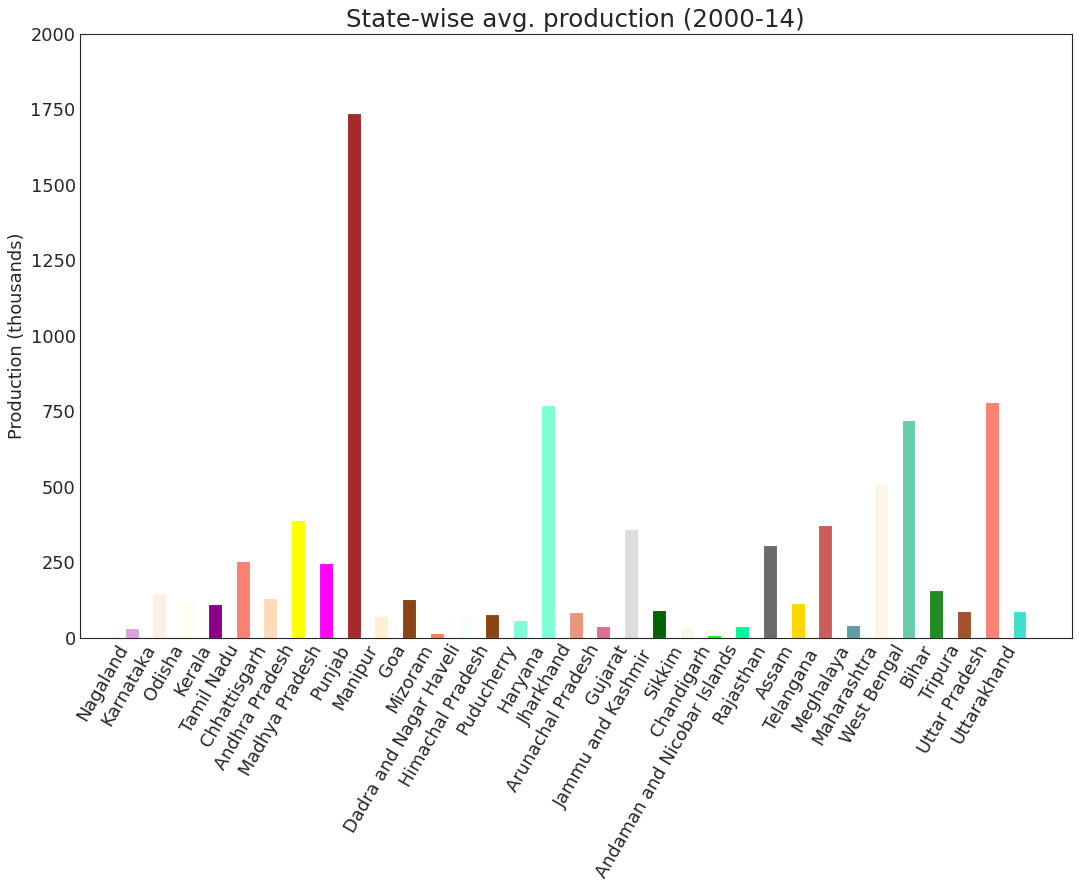

In [9]:
dataf = grp_statewise.toPandas();
# Prepare Data
n = dataf['State_Name'].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
c = random.choices(all_colors, k=n)

# Plot Bars
plt.figure(figsize=(16,10), dpi= 80)
plt.bar(dataf['State_Name'], dataf['avg_production']/100, color=c, width=.5)

# Decoration
plt.gca().set_xticklabels(dataf['State_Name'], rotation=60, horizontalalignment= 'right')
plt.title("State-wise avg. production (2000-14)", fontsize=22)
plt.ylabel('Production (thousands)')
plt.ylim(0, 2000)
plt.show()

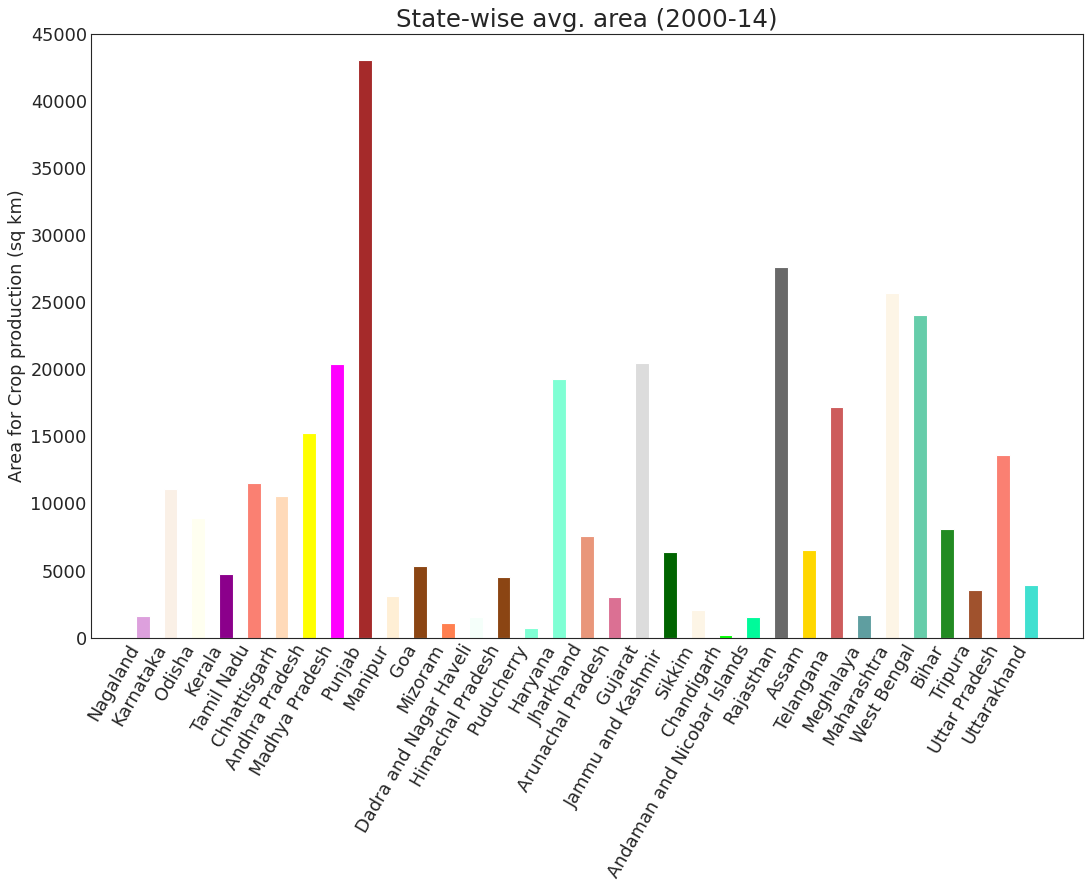

In [10]:
# Plot Bars
plt.figure(figsize=(16,10), dpi= 80)
plt.bar(dataf['State_Name'], dataf['avg_area'], color=c, width=.5)

# Decoration
plt.gca().set_xticklabels(dataf['State_Name'], rotation=60, horizontalalignment= 'right')
plt.title("State-wise avg. area (2000-14)", fontsize=22)
plt.ylabel('Area for Crop production (sq km)')
plt.ylim(0, 45000)
plt.show()

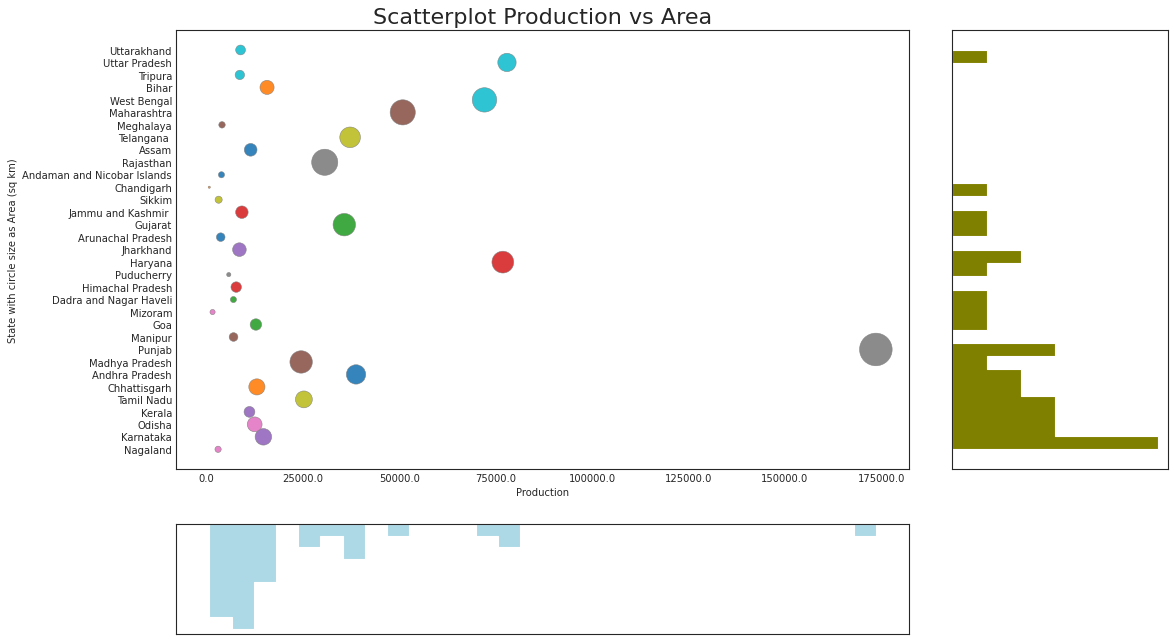

In [11]:
# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_centr = fig.add_subplot(grid[:-1, :-1])
ax_rgt = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bttm = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

# Scatterplot on main ax
ax_centr.scatter('avg_production', 'State_Name', s=dataf.avg_area/50, c=dataf['State_Name'].astype('category').cat.codes, alpha=.9, data=dataf, cmap="tab10", edgecolors='gray', linewidths=.5)

# histogram on the bottom
ax_bttm.hist(dataf.avg_production/1000, 30, histtype='stepfilled', orientation='vertical', color='lightblue', label="Area")
ax_bttm.invert_yaxis()

# histogram in the right
ax_rgt.hist(dataf.avg_area/50, 30, histtype='stepfilled', orientation='horizontal', color='olive')

# Decorations
ax_centr.set(title='Scatterplot Production vs Area', xlabel='Production', ylabel='State with circle size as Area (sq km)')
ax_centr.title.set_fontsize(20)
for item in ([ax_centr.xaxis.label, ax_centr.yaxis.label] + ax_centr.get_xticklabels() + ax_centr.get_yticklabels()):
    item.set_fontsize(9)

xlabels = ax_centr.get_xticks().tolist()
ax_centr.set_xticklabels(xlabels)
plt.show()

In [12]:
top_crops = cal_zone.groupBy("Crop", "Crop_Year")\
                    .agg(avg("Production").alias("avg_production"),
                         sum("Production").alias("sum_production"),
                         avg("Area").alias("avg_area"),
                         sum("Area").alias("sum_area"),
                         first("Season").alias("Season"),)\
                    .sort(col("Crop"), col("Crop_Year"), col("Season"), col("avg_production").desc())
top_crops.show(200)

+---------------+---------+------------------+------------------+------------------+------------------+-----------+
|           Crop|Crop_Year|    avg_production|    sum_production|          avg_area|          sum_area|     Season|
+---------------+---------+------------------+------------------+------------------+------------------+-----------+
|       Arecanut|     1998|              23.0|              23.0|              66.0|              66.0|Kharif     |
|       Arecanut|     2000|            3600.0|            7200.0|            2177.0|            4354.0|Kharif     |
|       Arecanut|     2001|            3650.0|            7300.0|            2177.0|            4354.0|Kharif     |
|       Arecanut|     2006|          2080.375|           16643.0|            1518.0|           12144.0|Rabi       |
|       Arecanut|     2007|              78.0|              78.0|              61.0|              61.0|Kharif     |
|       Arecanut|     2008|              79.0|              79.0|       

In [13]:
windowCropProd = Window.partitionBy("t_counter").orderBy(col("t_avg_production").desc())

grp_crp = top_crops.withColumn("CROPDET", struct( "Crop", "Crop_Year", "avg_production", "avg_area", "Season"))\
                   .withColumn("counter", lit(1))\
                   .groupBy("Crop")\
                   .agg(sum("counter").alias("count"),\
                        avg("avg_production").alias("t_avg_production"),\
                        collect_list('CROPDET').alias('set_CROPDET'))\
                   .withColumn("t_counter",lit(1))\
                   .filter((col("count") > 18))\
                   .withColumn("rank",row_number().over(windowCropProd))\
                   .filter((col("rank") <= 5))\

grp_crp.show()
dataf_top_crop = grp_crp.toPandas();

print(dataf_top_crop)

+---------+-----+------------------+--------------------+---------+----+
|     Crop|count|  t_avg_production|         set_CROPDET|t_counter|rank|
+---------+-----+------------------+--------------------+---------+----+
|Sugarcane|   19|  790396.497413747|[[Sugarcane, 1997...|        1|   1|
|    Wheat|   19| 161089.9876573991|[[Wheat, 1997, 17...|        1|   2|
|     Jute|   19|124076.92345882663|[[Jute, 1997, 134...|        1|   3|
|     Rice|   19|104846.64063169778|[[Rice, 1997, 103...|        1|   4|
| Soyabean|   19| 40833.16938767615|[[Soyabean, 1997,...|        1|   5|
+---------+-----+------------------+--------------------+---------+----+

        Crop  count  ...  t_counter rank
0  Sugarcane     19  ...          1    1
1      Wheat     19  ...          1    2
2       Jute     19  ...          1    3
3       Rice     19  ...          1    4
4   Soyabean     19  ...          1    5

[5 rows x 6 columns]


/usr/lib/python3.7/socket.py:660: ResourceWarning: unclosed <socket.socket fd=80, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54616), raddr=('127.0.0.1', 42703)>
  self._sock = None


/usr/lib/python3.7/socket.py:660: ResourceWarning: unclosed <socket.socket fd=80, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 35788), raddr=('127.0.0.1', 35831)>
  self._sock = None


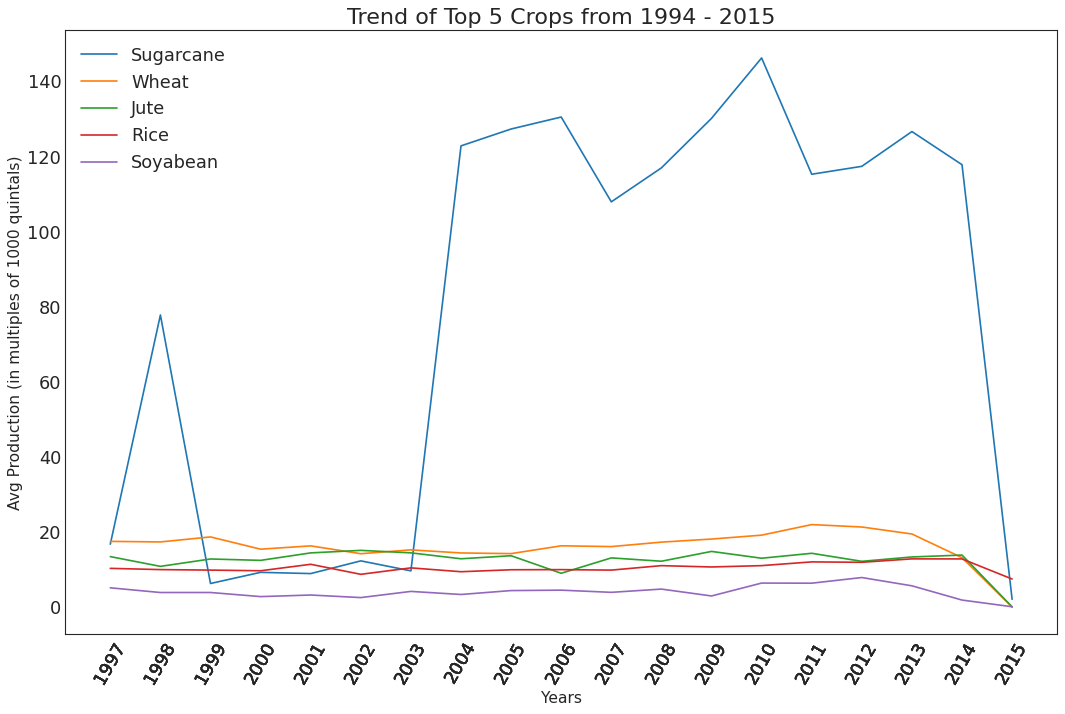

In [14]:
plt.figure(figsize=(16,10), dpi= 80)
years=[]
for row in grp_crp.collect():
    # print(row)
    # print(row.set_CROPDET)
    x = []
    y = []
    for innerRow in row.set_CROPDET:
        # print(innerRow)
        if innerRow["avg_production"] is None:
            continue
        years.append(innerRow["Crop_Year"])
        x.append(innerRow["Crop_Year"])
        y.append(innerRow["avg_production"]/10000)
    plt.plot(x,y, label=row["Crop"])
# years.unique()
plt.xticks(years, years, rotation='60')
plt.title('Trend of Top 5 Crops from 1994 - 2015', fontsize=20)
plt.xlabel('Years', fontsize=14) 
plt.ylabel('Avg Production (in multiples of 1000 quintals)', fontsize=14)
plt.legend()
plt.show()

## How does groundwater and canal water quality affect the crops of a region across the years 2012-2014

### Computation of Water Quality Index(WQI)

The WQI follows the methods reported in the below reference articles and videos -
- [Development of a water quality index (WQI) for the Loktak Lake in India](https://link.springer.com/article/10.1007/s13201-017-0579-4)
- [Assessment of Water Quality Index for the
Groundwater in Tumkur Taluk,
Karnataka State, India](http://www.indiaenvironmentportal.org.in/files/water%20quality%20index.pdf)
- [Youtube: Water Quality Index](https://www.youtube.com/watch?v=HTkNmmMoUzE)
- [Youtube: Calculation of Water Quality Index](https://www.youtube.com/watch?v=LtXfIYYb8F4)
- [IITK: Information on Driking Water Quality of Institute](http://iitk.ac.in/iwd/wq/drinkingwater.htm)

In [15]:
parameters= ['bod', 'conductivity', 'do', 'fluoride', 'nitrate', 'ph', 'total_fecal']
bis_value= {
    'conductivity': 300,
    'do' : 4, 
    'bod' : 3, 
    'fluoride' :1,
    'nitrate': 45,
    'ph' : 8.5,
    'total_fecal': 5000
}
ideal_bis_value= {
    'conductivity': 0,
    'do' : 14, 
    'bod' : 0, 
    'fluoride' :0,
    'nitrate': 0,
    'ph' : 7,
    'total_fecal': 0
}

i_bis_value={}
weight_bis_value={}
sum_i_bis_value = 0
sum_weight_bis_value = 0

for key in bis_value:
  i_bis_value[key] = 1 / bis_value[key]
  sum_i_bis_value += i_bis_value[key]

k_value = 1 / sum_i_bis_value

print(i_bis_value)
print(sum_i_bis_value, k_value)

for key in bis_value:
  weight_bis_value[key] = k_value / bis_value[key]
  sum_weight_bis_value += weight_bis_value[key]

print(weight_bis_value)
print(sum_weight_bis_value)

def cal_WiQi(param_value, param_name):
  try:
    if param_value is None:
      return float(0.0)
    param_value = float(param_value)
    q_num = (param_value - ideal_bis_value[param_name])
    q_deno = (bis_value[param_name] - ideal_bis_value[param_name])
    q_n = (q_num / q_deno) * 100
    if q_n < 0:
      q_n = (q_n * (-1))
    return float((weight_bis_value[param_name]) * q_n)
  except:
    return float(0.0)

# Provide UDF for usage in Pyspark
wiqi_udf_string = udf(lambda param_value, param_name : cal_WiQi(param_value, param_name), FloatType())


{'conductivity': 0.0033333333333333335, 'do': 0.25, 'bod': 0.3333333333333333, 'fluoride': 1.0, 'nitrate': 0.022222222222222223, 'ph': 0.11764705882352941, 'total_fecal': 0.0002}
1.7267359477124182 0.579127342153733
{'conductivity': 0.0019304244738457764, 'do': 0.14478183553843324, 'bod': 0.19304244738457765, 'fluoride': 0.579127342153733, 'nitrate': 0.012869496492305177, 'ph': 0.06813262848867446, 'total_fecal': 0.0001158254684307466}
0.9999999999999999


In [16]:

# parameters= ['conductivity', 'do', 'bod', 'fluoride', 'nitrate', 'ph', 'total_fecal']
cal_wqi = _wdf.select(
    col("year"), 
    lower(trim(col("state"))).alias("State"), 
    col("location"), 
    col("data_type"), 
    col("ph_mean"), 
    col("bod_mean"), 
    col("conductivity_mean"), 
    col("do_mean"), 
    col("fluoride_mean"), 
    col("nitrate_mean"), 
    col("station_code"), 
    col("temp_mean"), 
    col("total_coliform_mean"), 
    wiqi_udf_string(("bod_mean"), lit('bod')).alias('bod_wiqi'),
    wiqi_udf_string(("conductivity_mean"), lit('conductivity')).alias('conductivity_wiqi'),
    wiqi_udf_string(("do_mean"), lit('do')).alias('do_wiqi'),
    wiqi_udf_string(("fluoride_mean"), lit('fluoride')).alias('fluoride_wiqi'),
    wiqi_udf_string(("nitrate_mean"), lit('nitrate')).alias('nitrate_wiqi'),
    wiqi_udf_string(("ph_mean"), lit('ph')).alias('ph_wiqi'),
    wiqi_udf_string(("total_coliform_mean"), lit('total_fecal')).alias('total_fecal_wiqi'),
  ).withColumn("wqi", expr('bod_wiqi + conductivity_wiqi + do_wiqi + fluoride_wiqi + nitrate_wiqi + ph_wiqi + total_fecal_wiqi')
  # ).filter(
  #      (col("wqi") < 0)
      #  (col("wqi_status").isin("Unfit For Consumption"))
  # ).withColumn("row",row_number().over(windowRegion)
  ).withColumn("state_modified",
                when(col('state') == 'tamilnadu', "tamil nadu"
                ).when(col('state') == 'haryana/cpcb', "haryana"
                ).when(col('state').isin('daman, diu, dadra nagar haveli','daman', 'daman & diu', 'dadra & nagar haveli', 'dadra nagar haveli'), "dadra and nagar haveli"
                ).when(col('state') == "jammu & kashmir", "jammu and kashmir"
                ).when(col('state') == "cpcb, delhi", "delhi"
                ).when(col('state') == "chattissgarh", "chhattissgarh"
                ).when(col('state') == "orissa", "odisha"
                ).otherwise(col("state"))
  ).groupBy("state_modified", "year" # "data_type", 
  ).agg(
      # first(col("state")),
    avg("wqi").alias("avg_wqi"),
  ).withColumn("wqi_status", 
               when(col('avg_wqi') < 25, "Excellent"
               ).when(col('avg_wqi') < 50, "Good"
               ).when(col('avg_wqi') < 75, "Poor"
               ).when(col('avg_wqi') < 100, "Very Poor"
               ).otherwise("Unfit For Consumption")
  ).filter(
       (col("avg_wqi") > 0)
  ).sort(col("state_modified"),  col("year"), col("avg_wqi") #col("data_type"),
  )

cal_wqi.show(300, truncate=False)
cal_wqi.count()

+----------------------+----+------------------+---------------------+
|state_modified        |year|avg_wqi           |wqi_status           |
+----------------------+----+------------------+---------------------+
|andhra pradesh        |2012|127.45783972017693|Unfit For Consumption|
|andhra pradesh        |2013|126.55436060531065|Unfit For Consumption|
|andhra pradesh        |2014|138.90488023530034|Unfit For Consumption|
|arunachal pradesh     |2012|10.817107439041138|Excellent            |
|assam                 |2012|38.95781099319458 |Good                 |
|assam                 |2013|29.11172342777252 |Good                 |
|assam                 |2014|26.259941928386688|Good                 |
|bihar                 |2012|36.033361662615526|Good                 |
|bihar                 |2013|16.624159705283038|Excellent            |
|bihar                 |2014|22.091031127380877|Excellent            |
|chandigarh            |2012|284.63916062646445|Unfit For Consumption|
|chhat

92

### Computation of Agricultural Efficiency

Agricultural effciency is given by

$E_i = \frac{\sum I_{ij} \times C_{ij}}{\sum C_{ij}}$

Calculation for $I_{ij}$ -

$I_{ij} = \frac{Y_{ij}}{Y_i} \times 100$

where,
- $i$ is the crop and
- $j$ is the region
- $E_{i}$ is the Agricultural Efficiency
- $I_{ij}$ is the Ratio between the yield of any crop ($Y_{ij}$) of the individual Area '$i$' under the total area and the average yield rate of the entire area'$y$' of any crop multiplied by 100
- $C_{ij}$ = Area in % for individual crop in individual area unit

#### Reference

- [How to calculate Agricultural efficiency and mapping ](https://www.youtube.com/watch?v=MB_K_a0xo3g)

In [17]:
# cropdf.printSchema()
windowRegion = Window.partitionBy("RegionSeasonCrop_Year").orderBy(col("avg_production").desc())

cal_zone = _cdf.select(
        col("State_Name"), 
        col("District_Name"), 
        col("Crop_Year"), 
        col("Season"), 
        col("Crop"), 
        col("Area"), 
        col("Production"), 
        zone_udf_string(trim("State_Name")).alias('Region'),
    ).filter(
            (~(trim(col('Season')) == 'Whole Year'))
        &   (col("Crop_Year").isin(2012, 2013, 2014))
    ).withColumn("State_Name_Year", lower(concat('State_Name', 'Crop_Year'))
    ).withColumn("State_Crop_Year", lower(concat('State_Name', 'Crop', 'Crop_Year'))
    ).withColumn("State_District_Year", lower(concat('State_Name', 'District_Name', 'Crop_Year'))
    ).withColumn("State_District_Crop_Year", lower(concat('State_Name', 'District_Name',  'Crop', 'Crop_Year'))
    )

# print(cal_zone.count())
# cal_zone.show(5, truncate=False)

sum_prod = cal_zone.groupBy("State_District_Crop_Year" #"State_Name", "Crop", "Crop_Year"
    ).agg(
        sum("Area").alias('sum_Area'),
        # lower(first("State_Name")).alias('Crop_State'),
        # first("Crop"),
        # first("Season"),
        sum("Production").alias("sum_production"),
        # avg("Area").alias("avg_area"),
    ).sort(col("State_District_Crop_Year"),  col("sum_Area") , col("sum_production"),
    )
# print(sum_prod.count())
# sum_prod.show(20, truncate=False)

percentage_prod = cal_zone.join(
        sum_prod,
        (
            (cal_zone.State_District_Crop_Year ==  sum_prod.State_District_Crop_Year)
        ),
        "inner"
        # Area percentage C(ij)
    ).withColumn("percent_area", ((col("Area") * 100)/ col("sum_Area"))
    # Yield Y(ij)
    ).withColumn("yield", (col("Production") / col("Area"))
    # ).withColumn("percent_prod", ((col("Production") * 100)/ col("sum_production"))
    )
# print(percentage_prod.count())
# percentage_prod.show(5, truncate=False)

yield_avg = percentage_prod.groupBy("State_Crop_Year" #"State_Name", "Crop", "Crop_Year"
    ).agg(
        # Y(i)
        avg("yield").alias("avg_yield"),
    ).sort(col("State_Crop_Year"),  col("avg_yield"),
    )
# yield_avg.show(5, truncate=False)

percentage_yield_prod = percentage_prod.join(
        yield_avg,
        (
            (percentage_prod.State_Crop_Year ==  yield_avg.State_Crop_Year)
        ),
        "inner"
    # I(ij)
    ).withColumn("percent_yield", ((col("yield") * 100)/ col("avg_yield"))
    # I(ij) x C(ij)
    ).withColumn("efficiency_per_crop", (col("percent_yield") * col("percent_area"))
    # ).withColumn("percent_prod", ((col("Production") * 100)/ col("sum_production"))
    )
# percentage_yield_prod.show(20, truncate=False)
  
# State_District_Year
efficiency_df = percentage_yield_prod.groupBy("State_District_Year" #"State_Name", "Crop", "Crop_Year"
    ).agg(
        first("State_Name_Year").alias('State_Name_Year'),
        first("State_Name").alias('State_Name'),
        first("Crop_Year").alias('Crop_Year'),
        sum("percent_area").alias("sum_Yield"),
        sum("efficiency_per_crop").alias("sum_efficiency_per_district"),
    ).withColumn("efficiency_per_district", (col("sum_efficiency_per_district") / col("sum_Yield"))
    ).sort(col("State_District_Year"),  col("sum_Yield"),
    )
efficiency_df.show(5, truncate=False)

grp_statewise = efficiency_df.groupBy("State_Name_Year" #"State_Name", "Crop", "Crop_Year"
    ).agg(
        first("Crop_Year").alias('Crop_Year'),
        lower(first("State_Name")).alias('Crop_State'),
        avg("efficiency_per_district").alias("efficiency_per_state"),
    ).sort(col("State_Name_Year"),  col("efficiency_per_state") #col("data_type"),
    )
print(grp_statewise.count())
grp_statewise.show(5, truncate=False)

+---------------------------+------------------+--------------+---------+---------+---------------------------+-----------------------+
|State_District_Year        |State_Name_Year   |State_Name    |Crop_Year|sum_Yield|sum_efficiency_per_district|efficiency_per_district|
+---------------------------+------------------+--------------+---------+---------+---------------------------+-----------------------+
|andhra pradeshanantapur2012|andhra pradesh2012|Andhra Pradesh|2012     |3700.0   |322735.27987776685         |87.22575131831536      |
|andhra pradeshanantapur2013|andhra pradesh2013|Andhra Pradesh|2013     |4000.0   |351460.3951984018          |87.86509879960046      |
|andhra pradeshanantapur2014|andhra pradesh2014|Andhra Pradesh|2014     |4000.0   |338846.8436114159          |84.71171090285397      |
|andhra pradeshchittoor2012 |andhra pradesh2012|Andhra Pradesh|2012     |3800.0   |334795.6885886458          |88.10412857595941      |
|andhra pradeshchittoor2013 |andhra pradesh2013|

### Combining WQI and Agricultural Efficiency

In [18]:
combined_df = cal_wqi.join(
        grp_statewise,
        (
            (cal_wqi.year ==  grp_statewise.Crop_Year) 
            &
            (cal_wqi.state_modified ==  grp_statewise.Crop_State)
        ),
        "inner"
    ).withColumn("2012_wqi", when(col("year").isin(2012),col("avg_wqi")).otherwise(lit(0.0))
    ).withColumn("2013_wqi", when(col("year").isin(2013),col("avg_wqi")).otherwise(lit(0.0))
    ).withColumn("2014_wqi", when(col("year").isin(2014),col("avg_wqi")).otherwise(lit(0.0))
    ).withColumn("2012_eiff", when(col("year").isin(2012),col("efficiency_per_state")).otherwise(lit(0.0))
    ).withColumn("2013_eiff", when(col("year").isin(2013),col("efficiency_per_state")).otherwise(lit(0.0))
    ).withColumn("2014_eiff", when(col("year").isin(2014),col("efficiency_per_state")).otherwise(lit(0.0))
    ).groupBy("state_modified").agg(
        sum("2012_wqi").alias("2012_wqi"),
        sum("2013_wqi").alias("2013_wqi"),
        sum("2014_wqi").alias("2014_wqi"),
        sum("2012_eiff").alias("2012_eiff"),
        sum("2013_eiff").alias("2013_eiff"),
        sum("2014_eiff").alias("2014_eiff"),
    ).filter(
        ((~(col("2012_wqi") == 0.0))
        & (~(col("2013_wqi") == 0.0))
        & (~(col("2014_wqi") == 0.0)))
        | ((~(col("2012_eiff") == 0.0))
        & (~(col("2013_eiff") == 0.0))
        & (~(col("2014_eiff") == 0.0)))
    ).sort(col("state_modified")#,  col("year"), col("avg_wqi") #col("data_type"),
    )

combined_df.show(300, truncate=False)
combined_df.count()

+----------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|state_modified        |2012_wqi          |2013_wqi          |2014_wqi          |2012_eiff         |2013_eiff         |2014_eiff         |
+----------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|andhra pradesh        |127.45783972017693|126.55436060531065|138.90488023530034|101.77786531013012|100.31485464949711|99.41054604319594 |
|assam                 |38.95781099319458 |29.11172342777252 |26.259941928386688|100.70133003519595|100.15603597801862|100.2854789933227 |
|bihar                 |36.033361662615526|16.624159705283038|22.091031127380877|99.86137729767954 |100.0522380849604 |100.68668977846609|
|chhattisgarh          |27.39777500288827 |22.8699064122306  |24.20482963985867 |98.11095989515267 |96.37566666516692 |96.95047144155643 |
|dadra and nagar haveli|40.

17

/usr/lib/python3.7/socket.py:660: ResourceWarning: unclosed <socket.socket fd=81, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 43726), raddr=('127.0.0.1', 38749)>
  self._sock = None


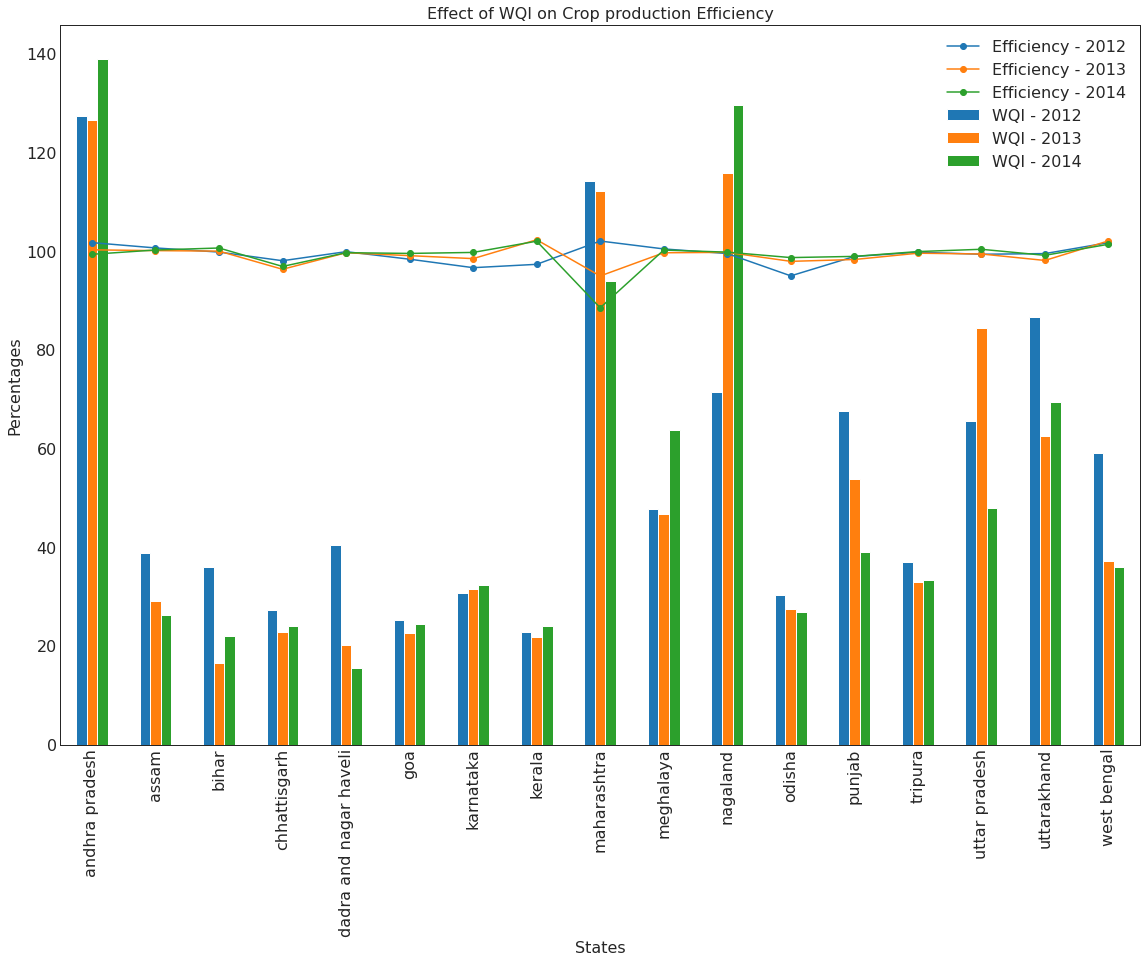

In [19]:
dataSet = combined_df.toPandas();

ax = dataSet[['state_modified', '2012_eiff', '2013_eiff', '2014_eiff']].plot(
    x='state_modified', linestyle='solid', marker='o', title='Effect of WQI on Crop production Efficiency')
dataSet[['state_modified', '2012_wqi', '2013_wqi', '2014_wqi']].plot(x='state_modified', kind='bar', ax=ax)

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


set_size(15,10)
ax.set_xlabel("States")
ax.set_ylabel("Percentages")
ax.legend(["Efficiency - 2012", "Efficiency - 2013", "Efficiency - 2014", "WQI - 2012", "WQI - 2013", "WQI - 2014"]);
plt.show()